__Goal__: of this notebook is to have a glimpse on how easy it is to play with neural networks with Pytorch and illustrate the expressive power and versatility of neural networks:
- We first go through their discriminative power (i.e. classification) on the very classical MNIST data-set. In particular we see how to
    - Define a neural model as a torch.nn.Module.
    - Have a glimpse at convolutional layers, activations etc...
    - Use DataLoader and Data-Augmentation and the intimate link with Stochastic Gradient Descent.
    - How to train the model with optimizers.
    - Perform inference!

- Then we explore neural network representation with fun application like style transfer.
    - Load a pre-trained model.
    - What the model has learnt at each layer.
    - How to define the style transfer problem.
    - Play with it!

- If we have time we go over auto-encoder to explore the 'latent space' of these models.

__Recommended sources__: http://cs231n.github.io/

# 1) First Part: Discriminative Network (classification) on MNIST

__Load the MNIST dataset__

In [2]:
%matplotlib inline
import torch
import torch.nn as nn
import torchvision  # for the datasets.
import torchvision.transforms as transforms

# Which transformations to apply to each data point when sampling data point.
# Here simply transform the data-point into a tensor and normalize it.
# A tensor is just a multidimensional matrix!
# torch.tensor is 'equivalent' to np.array
transform = transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                (0.1307,), (0.3081,))
                                           ])


mnist_train = torchvision.datasets.MNIST('data/', train=True, transform=transform,
                                         target_transform=None, download=True)
mnist_test = torchvision.datasets.MNIST('data/', train=False, transform=transform,
                                        target_transform=None, download=True)


batch_size_train = 64  # often a power or 2.  
data_loader_train = torch.utils.data.DataLoader(mnist_train,
                                                batch_size=batch_size_train,
                                                shuffle=True)

## <font color=darkred> Convolutional Neural Network </font>

In practice, increasing the size of hidden layers is not very effective. 
It is often a better idea to add more layers. 
Intuitively, if the observations have a hierarchical structure, adding more layers can be interpreted as a way to learn more levels of abstraction.  For example, in object detection tasks, it is easier to express shapes from edges and objects from shapes, than to express objects from pixels.  Thus, a good design should try to exploit this hierarchy.

In particular cases, such as grid-like data (time series, images), the observations can depend on a pattern which can be associated with different locations of the data. 
For example, an object can be in the middle or the left of the picture. 
Thus, the model has to be translation invariant: it is easier to learn how to recognize an object independently of its location. 

When two inputs might contain the same kind of information, then it is useful to share their weights and estimate the weights jointly for those inputs to learn statistical invariants (things that don't change much on average across time or space). 
Using this concept on images leads to convolutional neural networks (CNNs), on text, it results on recurrent neural networks (RNNs).  When using CNNs, weights are set to a small kernel that is used to perform a convolution across the image.

In Keras, the step ``model_ffnn.add(Flatten(input_shape=input_shape))`` destroys the spatial organization of the input but is mandatory before a fully connected step: ``model_ffnn.add(Dense(128, activation='relu'))``. The spatial organization of the input may be preserved before using Flatten by convolution steps such as ``model_cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))``. This layer has 32 outputs, each of which depending on a 3*3 weight matrix.

Each output neuron of the next layer is computed as follows (image taken from https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-tensorflow/) before computing an elementwise RELU function:
<img src="./conv.png">

The convolution maps patches of the input image, combined with the convolution kernel, for example
$$
\text{output} = \text{ReLU}(\text{patch} \times W + b)\,.
$$

Performing the convolution between the image and the weight matrix consists in moving the kernel across the image, and to produce an output for each patch. The way you move across the image is defined by two parameters:

- ``Stride``: the stride is the number of pixels you are shifting each time you move your kernel during the convolution.
- ``Padding``: defines what happens when the kernel reaches a border of the image when doing the convolution. 
"Valid" padding means that you stop at the edge, while "Same" padding allows to go off the edge and pad with zeros so that the width and the height of the output and input tensors are the same.

A classical approach is to use a stride of 1 and to combine theoutputs being in some neighborhood. Such an operation combining elements of a tensor is called ``pooling``: ``model_cnn.add(MaxPooling2D(pool_size=(2, 2)))``. Neighborhoods are define by the pooling window dimension (width x height) and the strides you use when moving this window across the image.  Again, a sliding window is applied along the input to produce the output, the most common function applied on each window being the ma function: it aggregates several outputs in a neighborhood $N$ using a max operation: 
$$
\text{output}'_i = \max_{j \in N}\text{output}_j, \quad i \in N.
$$
The formulas to compute the size of the ouput tensor are the same as for convolution padding and striding: (image taken from https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-tensorflow/):
<img src="maxpool.png">

Dit autrement, au lieu d'aplatir la matrice de données en un vecteur (flatten) comme dans le FFNN, on conserve son "organisation spatiale" et on applique non pas une transormation linéaire + activation, mais un produit de convolution, en utilisant un noyau de convolution. Un noyau de convolution (pas de rapport avec le kernel trick) est une petite matrice carrée (3x3 ou 5x5), qu'on applique successivement à chaque voisinage de nos données. On le déplace de gauche à droite et de haut en bas, avec des régles un peu arbitraires dictées par la pratique (et qu'on peut gérer dans les hyperparamètres : autorise-t-on le overlap, etc.). Un déplacement à droite produit une nouvelle colonne dans la matrice de résultats de la couche intermédiaire, un déplacement vertical produit une nouvelle colonne. Les calculs sont plus complexes et plus longs si on chosit un noyau plus gros, qui produit de plus grosses couches intermédiaires.

Ainsi, on conserve dans les résultats de la couche convolutionnelle des informations pertinentes liées au voisinage de chaque point. C'est pour cette raison que cette méthode est très utilisée dans le traitement d'image : les pixels à chaque endroit de l'image sont bien liés entre eux. Exemple parlant : avec un FFNN le modèle arrive bien à repérer et reproduire les différentes caractéristiques d'une image, par ex un chat, mais ne garde pas sa structure spatiale, et pourrait donc produire une image désordonnée avec la tête au mauvais endroit, etc.

Comme dans le FFNN la dernière couche doit produire un vecteur de taille 10 (si on a 10 classes) avec la proba de chaque classe. On peut d'ailleurs faire se succéder 1 couche convulutionnelle et plusieurs autres couches entièrement liées (feed forward).

L'enjeu aujourd'hui dans les réseaux de détection d'image, est de conserver non seulement l'organisation spatiale dans les représentations cachées (à chaque couche du modèle), mais aussi d'extraire avec le modèle des informations comme le flou, le plissé des vêtements, les différences d'éclairage, les contours - cela pour éviter les erreurs de classification (ex: classer différemment le même vêtement car sur une photo il est plissé). En utilisant des CNN complexifiés, avec d'autres fonctions, d'autre transformations, d'autres noyaux, il est possible d'intégrer ces subtilités dans le modèle. Chaque couche représente alors une partie de l'information de l'image. La mode en ce moment est d'analyser les images satellites avec ces méthodes.

Le transfert de style, aujourd'hui, est une méthode qui consiste à tirer profit de modèles préentraînés très complexes (entraînés par Google / Facebook, seuls ou presque avec la puissance nécessaire), qui extraient beacoup d'informations des images. On sélectionne un gros modèle entraîné sur des images similaires aux nôtres, et on sélectionne seulement les couches (et donc les paramètres) qui concernent notre problème, puis on fait du fine-tuning pour construire notre nouveau modèle.

L'enjeu suivant, aujourd'hui, est de pouvoir expliquer comment fonctionne ce genre de modèle, i.e. quelle est l'influence de chaque paramètre dans le résultat du modèle (ex : quand on essaie de détecter des cancers il faudrait idéalement comprendre précisément comment le modèle fonctionne, pas seulement minimiser l'erreur). Aujourd'hui, ces modèles restent souvent justifiés par la pratique seule.

Ce problème est encore complexifié dans le cas du transfert de styles : si on utilise un modèle pré-entraîné très sophistiqué, on leur donne finalement les clés de notre travail, on ne connaît pas forcément le détail de leurs choix dans le training du model (leurs choix éthiques, leur sélection de données, tous leurs choix qui finalement biaisent le modèle). Le nerf de la guerre aujourd'hui n'est plus tellement la puissance de calcul mais l'éthique dans l'utilisation des jeux de données.

In [3]:
import torch.nn.functional as F

# This is the very generic structure for neural models.
# nn.Conv2d(nbr_input_channel, nbr_output_channel, size_kernel)
# Be careful of the dimension for the First Linear layer (= fully-connected).
class LeNet5(nn.Module):
    def __init__(self):
        # This
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, (5, 5), padding=2)
        self.conv2 = nn.Conv2d(4, 16, (5, 5))
        self.lin1 = nn.Linear(16*5*5, 120)
        self.lin2 = nn.Linear(120, 84)
        self.lin3 = nn.Linear(84, 10)
        self.name = 'LeNet5'

    def forward(self, x):
        # simply define the forward pass.
        x = F.relu(F.max_pool2d(self.conv1(x), (2, 2)))
        x = F.relu(F.max_pool2d(self.conv2(x), (2, 2)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        # Note that we are outputing 
        return x

__Train the Model__


#### <font color=darkred> Optimization methods for neural networks (bonus) </font>

Today, a few gradient descent algorithms are the most popular:

``The ADAptive GRADient`` algorithm introduced by http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf, (Duchi et al. 2011), starts from $w^{(0)}$ and uses a learning rate $\eta > 0$ and a momentum $\alpha$ and defines, for all $k\geqslant 0$ and all $j \in\{1, \ldots , d\}$, 
$$
w_j^{(k+1)} \gets w_j^{(k)}  - \frac{\eta}{\sqrt{\sum_{\tau=1}^k (\nabla f (w^{(\tau)}))_j^2}} (\nabla f(w^{(k)}))_j\,.
$$
The rationale of this method is that different rates are used for all coordinates which is crucial for neural networks in which gradient at different layers can be of different order of magnitude. It is proved in https://arxiv.org/pdf/1806.01811.pdf (Ward et al., 2018) that AdaGrad achieves the same convergence rate as gradient descent with optimal fixed stepsize up to a $\log$ factor. The adaptive step size grows with the inverse of the gradient magnitudes, so that large gradients have small learning rates and small gradients have
large learning rates.

``AdaDelta`` Introduced in https://arxiv.org/pdf/1212.5701.pdf (Zeiler, 2012) to reduce the sensitivity to initial conditions of AdaGrad. Indeed, if the initial gradients are large, the learning rates of AdaGrad will be low for all updates which can be overcome by increasing $\eta$, but making the AdaGrad method highly sensitive to the choice of $\eta$.  


``RMSprop optimizer`` Unpublished method, from the course of http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf (Geoff Hinton).


``ADAM: Adaptive moment estimation`` Introduced in https://arxiv.org/pdf/1412.6980.pdf (Kingma et al., 2014) and considered as the state-of-the-art to otpimize neural networks (it's the default algorithm in keras), the ADAM procedure is a stochastic gradient descent and updates the parameter estimate as follows. Starting from $m_0 = 0$ and $v_0=0$ and choosing $\beta_1, \beta_2, \eta, \varepsilon
 \in (0,1)$, compute first and second moment estimate 
$$
m_k = \beta_1 m_{k-1} + (1 - \beta_1) \nabla f (w^{(k)}) \quad  \mathrm{and} \quad v_k = \beta_2 v_{k-1} + (1 - \beta_2) (\nabla f (w^{(k)}))^2\,,
$$
then, compute the correction terms
$$
\hat{m}_k = \frac{m_k}{1 - \beta_1^k} \quad \hat{v}_k = \frac{v_k}{1 - \beta_2^k}\,,
$$
and update the parameter estimate with
$$
w^{(k+1)} = w^{(k)} - \frac{\eta}{\sqrt{\hat{v}_k}+ \varepsilon} \hat{m}_k\,.
$$
First convergence results can be found in https://arxiv.org/pdf/1412.6980.pdf (Kingma et al., 2014), but careful: some counter-examples where ADAM algorithm does not converge to the optimum (i.e. a false theorem in Kingma's paper) are given in https://openreview.net/pdf?id=ryQu7f-RZ (Reddi et al., 2018). It doesn't invalidate the global results of the paper, and the fact that this algorithm almost always works in practice - even though most people don't really understand the details (what's in the step size, etc.). See also other recent analysis by https://arxiv.org/abs/1810.02263 (Barakat et al., 2018).

In [ ]:
import torch.optim as optim

model = LeNet5()
model.train()
nbr_epoch = 5  # Number of time we visit the full data set. Up to you and your test loss

# Choose on which device to store the tensor (i.e. the tensor of the weights)
# Here it does not apply, you train things of cpu, but it is just to observe how easy it is with pytorch
# to adapt to the computer infrastructure.
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

# Define the loss!
criterion = nn.CrossEntropyLoss()  # You can choose many others!
# Same as nn.NLLLoss() but this one takes the logsoftmaxes, not the logit...

# Choose your optimizer and parameters!
# usually there are some guidelines on how to choose the hyper-parameters. Or CV...
learning_rate = 0.01
momentum = 0.9
optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate,
                      momentum=momentum)

for idx_epoch in range(nbr_epoch):
    counter = 0
    for batch_idx, (data, target) in enumerate(data_loader_train):
        # set the data to the right device
        data = data.to(device)
        target = target.to(device)
        # forget the previous gradient.
        optimizer.zero_grad()
        logit = model(data)
        loss = criterion(logit, target)
        # compute the gradients!!
        loss.backward()
        # Essentially do gradient descent, i.e. weight_{t+1} = weight_t - lr* gradient...
        optimizer.step()
        counter += 1
        if counter % 100 == 0:
            print('batch {} at epoch {} with loss {}'.format(counter,
                                                             idx_epoch,
                                                             loss.item()))
    # save the model!
    # TODO: check that the folder mnist_models/ exists!
    torch.save(model.state_dict(), 'mnist_models/' + '_epoch_' + str(idx_epoch))

Plus on apprend sur le jeu de train (au fil des epochs / échantillonnages), plus on aura un bon score sur le jeu de test, jusqu'à un certain point : passé un certain point notre accuracy en test va baisser, parce qu'on overfit, i.e. on apprend à bien prédire les aléas sur notre échantillon de train, mais cette précision nuit à nos prédictions sur un échantillon différent. C'est pour cette raison que la test accuracy s'améliore sutr l'échantillon test (voir ci-dessous) jusqu'à l'epoch 3, mais redescend sur l'epoch 4.

__Evaluate the model__

In [5]:
# accuracy on test of the big network
data_loader_test = torch.utils.data.DataLoader(mnist_test,
                                               batch_size=1,
                                               shuffle=True)

def accuracy(model, data_loader_test, nbr=1000):
    pos = 0
    count = 0
    for data, target in data_loader_test:
        data = data.to(device)
        target = target.to(device)
        assert target.shape[0] == 1
        if torch.argmax(model(data).squeeze()).item() == target.item():
            pos += 1
        count += 1
        if count > nbr:
            break
    accuracy = pos/count
    return(accuracy)

for idx in range(nbr_epoch):
    PATH = 'mnist_models/_epoch_{}'.format(idx)
    model.load_state_dict(torch.load(PATH))
    model.to(device)
    model.eval()  # Do it for principle..
    acc = accuracy(model, data_loader_test)
    print('test accuracy is {} at epoch {}'.format(acc, idx))

test accuracy is 0.978021978021978 at epoch 0
test accuracy is 0.974025974025974 at epoch 1
test accuracy is 0.988011988011988 at epoch 2
test accuracy is 0.99000999000999 at epoch 3
test accuracy is 0.989010989010989 at epoch 4


__How to Data Augmentation in Two lines:__ It is simply small transformation of the images that do not modify the label. For instance
- Add some random pixel-wise noise
- flip the image
- translate the pixel etc..

There is a very large variety of possible data-augmentation. When training your network and load batche of data, the data-point will be applied the following transformation:

In [6]:
transform = torchvision.transforms.Compose([
                                            transforms.RandomHorizontalFlip(0.5),
                                            transforms.RandomAffine(degrees=10,
                                                                    translate=(0.1, 0.1)),
                                           torchvision.transforms.ToTensor(),
                                           torchvision.transforms.Normalize(
                                            (0.1307,), (0.3081,))
                                           ])

__How to Randomly Initialize the Parameters:__ Because so far we have not specified what we wanted the initial weights to be!!

In [ ]:
import numpy as np

# There are many way to define randomness on the initialization of the weights.
def init_weights(m, type_ini='uniform'):
    '''
    Initialization of neural net.
    '''
    assert type_ini in ['uniform', 'gaussian', 'general']
    # for every Linear layer in a model..
    if type(m) == nn.Linear:
        if type_ini == 'uniform':
            m.weight.data.uniform_(0.0, 1.0)
            m.bias.data.fill_(0) # usual practice is to set bias to 0
        elif type_ini == 'general':
            n = m.in_features
            y = 1.0/np.sqrt(n)
            m.weight.data.uniform_(-y, y)
            m.bias.data.fill_(0)
        elif type_ini == 'gaussian':
            y = m.in_features
            # m.weight.data shoud be taken from a normal distribution
            m.weight.data.normal_(0.0, 1/np.sqrt(y))
            # m.bias.data should be 0
            m.bias.data.fill_(0)

model.apply(lambda m: init_weights(m, type_ini='general'))

# Second Part: Style Transfert

__Goal__: Neural Networks are not just good at classifying, they also provide rich representations of data which can be usefull in a variety of contexts.

__Example of Style Transfert__: Write $f_{\theta_0}$ a trained neural network with parameters $\theta_0$ (which will not be optimized anymore). And now consider two images: image_content and image_style. We want to change the style of image_content to the style of image_style while keeping the structure of image_content.

__One important fact__: Layers of convolutional neural networks encode different information of an image. Each layer output is a different representation of the image. The first layers encodes detailed information (i.e. style) because the networks has not yet mixed up local information. The last layers encode more the content because it mixes the various local structures.

__Method__: Take an initial random image $x$ and ask simultaneously that 
 - The deep layers of x via $f_{\theta}$ matches to the deep layers of image_content : i.e. force $x$ to have the content of image_content.
 - The Gram matrix of the first layers of x via $f_{\theta}$ matches to gram matrix of the first layers of image_content : i.e. force $x$ to have the style of image_style.
 
__Technical Aspect__: Optimization is over the input of the neural network, not on its weigths!!

__Reference__: 
- Simonyan et Zisserman (2015). $\textit{Very Deep Convolutional Networks For Large Scale Image Recognition}.$
- Gatys et al. (2015). $\textit{Image Style Transfer Using Convolutional Neural Networks}.$
- https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

__Pytorch tips__:
- Very easy to work with CPU or GPU via making sure that the tensors are on 'cpu' or 'cuda'.
-

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torchvision.models as models
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.utils import save_image

import pdb  # good for debugging!!

import copy
from PIL import Image  # for image processing!

__LOAD CONTENT AND STYLE IMAGE__ Please choose your own images!

In [5]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

imsize = 128


def image_loader(image_name):
    loader = transforms.Compose([
        transforms.Resize((imsize, imsize)),  # scale imported image
        transforms.ToTensor()])  # transform it into a torch tensor
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions of (batch_size, channel, H, W)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


content_img = image_loader('images/content.jpg')
style_img = image_loader('images/style.jpg')

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

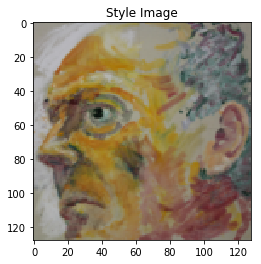

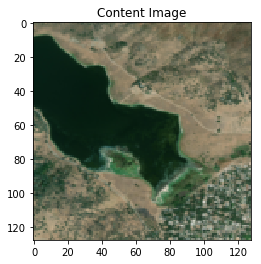

In [6]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

__Load pre-trained model__


In [7]:
# two modes: eval() or train()
# may not be usefull here but it is a good habit to distinguish!
model = models.vgg19(pretrained=True).features.to(device).eval()

__Defining the content and Style Loss:__ 
- Given an image $x$ and a chosen $\text{content layer}$, write $f_c(x)$ the activations of the neural network at this layer. The content loss is then $L_c(x) = ||f_c(x) - f_c(img_{content})||_2^2$.
- For the style write $f_s(x)$ the activations of the neural network at a chosen layer that is supposed to capture the style. The style loss is then $L_s(x) = ||G(f_s(x)) - G(f_s(img_{style}))||$, where $G()$ compute the gram matrix of the layer $f_s(x)$.

In [8]:
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()

        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input


class StyleLoss(nn.Module):

    def gram_matrix(self, input):
        a, b, c, d = input.size()  # a=batch size(=1)
        # b=number of feature maps
        # (c,d)=dimensions of a f. map (N=c*d)

        features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(a * b * c * d)

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = self.gram_matrix(target_feature).detach()

    def forward(self, input):
        G = self.gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

__Normalization term__ 
When training VGG the input images are normalized. This normalization is hence reproduced.

In [8]:
normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)


# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

__Define what are the style and content layers__ The method $\textit{get_style_model_and_losses}$ defines a way to define the loss associated to each chosen content or style layers.

In [9]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer')

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

__Initialize the optimization__


In [ ]:
# INITIALIZATION
# starting from content image.
input_img = content_img.clone()
# starting from noise -> need a lot more data.
# input_img = torch.randn(content_img.data.size(), device=device)

# OPTIMIZATION PARAMETERS
optimizer = optim.Adam([input_img.requires_grad_()], lr=0.005)
num_steps = 3000
style_weight = 500000
content_weight = 1

model, style_losses, content_losses = get_style_model_and_losses(model,
        normalization_mean, normalization_std, style_img, content_img)

In [ ]:
counter = 0
while counter <= num_steps:
    # correct the values of updated input image
    input_img.data.clamp_(0, 1)

    optimizer.zero_grad()
    model(input_img)
    style_score = 0
    content_score = 0

    for sl in style_losses:
        style_score += sl.loss
    for cl in content_losses:
        content_score += cl.loss

    style_score *= style_weight
    content_score *= content_weight

    loss = style_score + content_score
    loss.backward()  # compute the gradients.

    # plot the loss from time to time...
    counter += 1
    if counter % 50 == 0:
        print("run {}:".format(counter))
        print('Style Loss : {:4f} Content Loss: {:4f}'.format(
            style_score.item(), content_score.item()))
        print()

    if counter % 100 == 0:
        img_plot = input_img.clone().detach().data
        plt.figure()
        imshow(img_plot, title='Output Image')
        save_image(img_plot,
                   'images/in_between/img_' + str(counter) + '.jpg',
                   nrow=4)
        plt.show()
    # gradient descent step
    optimizer.step()

# a last correction...
input_img.data.clamp_(0, 1)

Output is the image at each step.

__Observe the result__

In [ ]:
plt.figure()
imshow(input_img, title='Output Image')
plt.ioff()
plt.show()

__Make a GIF out of the image__

In [ ]:
frames = [Image.open('images/in_between/img_' + str(i*100) + '.jpg') for i in range(1, 30)]
frames[0].save('animation.gif',
               format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=100,
               loop=0)